# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [2]:
# !pip install numpy pandas catboost -q
# !ls ../data/ # проверяем наличие данных

In [4]:
import numpy as np
import pandas as pd

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - годы выпуска машины и начала работы в автопарке 
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
423,V43499402t,Nissan Qashqai,standart,petrol,3.90,2013,39812,2020,100.05,another_bug
903,z10430541i,Mini Cooper,business,petrol,4.20,2013,36149,2021,50.54,engine_fuel
1068,O19079001s,Smart ForFour,economy,petrol,2.36,2013,37841,2017,31.08,electro_bug


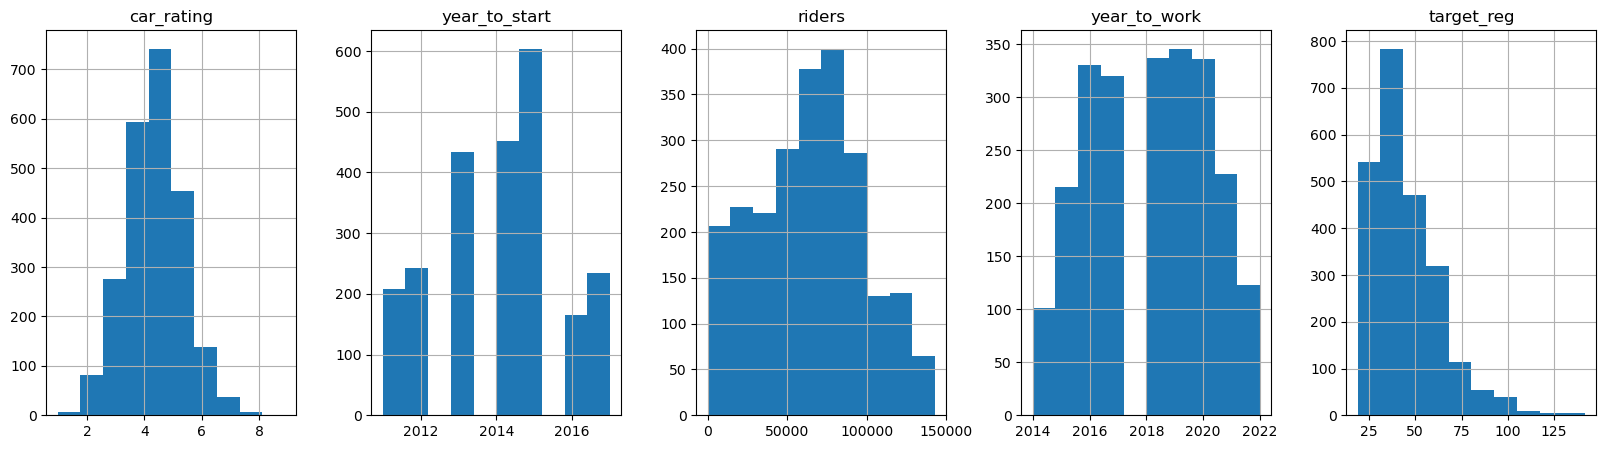

In [7]:
path = '../data/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(20, 5), layout = (-1, 5))
train.sample(3)

In [9]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


In [11]:
path = '../data/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(3)

(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
1216,x13343580w,Smart Coupe,economy,petrol,3.58,2017,113749,2016
488,a-1426275y,Kia Sportage,standart,petrol,5.18,2014,61166,2017
1616,x83440968Q,VW Polo,economy,petrol,4.44,2012,26882,2021


## Классифицируем признаки на типы

In [13]:
features2drop = ['car_id'] # то, что надо выбросить 
targets = ['target_class', 'target_reg'] # таргеты
cat_features = ['car_type', 'fuel_type', 'model'] # категориальные признаки
#------------------------

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Обучаем Catboost и делаем прогноз на тест

In [19]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #, mean_squared_error

In [21]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 218ms	remaining: 3m 37s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 17s	remaining: 1m 35s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 31.6s	remaining: 1m 13s
450:	learn: 0.9655173	test: 2.4024298	best: 2.1908935 (6)	total: 44.9s	remaining: 54.6s
600:	learn: 0.7488971	test: 2.4913589	best: 2.1908935 (6)	total: 58.3s	remaining: 38.7s
750:	learn: 0.5826318	test: 2.5762847	best: 2.1908935 (6)	total: 1m 11s	remaining: 23.6s
900:	learn: 0.4643456	test: 2.6651694	best: 2.1908935 (6)	total: 1m 24s	remaining: 9.24s
999:	learn: 0.4027101	test: 2.7091668	best: 2.1908935 (6)	total: 1m 35s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [23]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v1.csv', index=False)
print('CSV file saved!')

CSV file saved!


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [29]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
68470,S97707558k,E51339321G,H1H,2020-02-16,4.41,177,1642,31,175.000000,11,1668.903126,0,5.211900,0.001
465873,y21944121N,g88678216g,r1V,2020-02-09,2.49,38,375,41,71.000000,1,1501.378935,0,-1.523132,-16.010
107881,T11392225L,H22200136U,V1P,2020-01-01,7.08,56,723,49,90.000000,1,2558.947314,0,0.652384,1.772
239404,Q19562155K,Q21391218q,N1a,2020-03-22,3.55,40,395,81,86.126872,0,3284.680190,0,-22.094295,-56.544
416466,X20190007y,d-7058280z,F1K,2020-02-14,6.96,22,279,44,51.000000,0,906.231365,0,2.095958,0.000


In [31]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('rating', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [33]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [35]:
train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
1837,t-8867045F,Kia Sportage,standart,petrol,3.54,2015,95693,2014,103.47,another_bug,4.796207,6.731661e+06,0.1,174.00000,-4.219259,174,173
299,M-1009693J,Kia Rio,economy,petrol,5.44,2015,72820,2020,33.72,electro_bug,4.134885,9.216588e+06,0.0,178.79244,21.572611,174,172


In [39]:
train.to_csv('../tmp_data/quickstart_train.csv', index=False)

In [41]:
test.to_csv('../tmp_data/quickstart_test.csv', index=False)

# Снова обновляем типы фичей

In [44]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [47]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

# инференс модели
y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.8475119	test: 1.8655808	best: 1.8655808 (0)	total: 77.2ms	remaining: 1m 17s
150:	learn: 0.3200590	test: 0.5547029	best: 0.5540463 (147)	total: 15.2s	remaining: 1m 25s
300:	learn: 0.1971982	test: 0.5615205	best: 0.5513186 (167)	total: 31.3s	remaining: 1m 12s
450:	learn: 0.1375334	test: 0.5712868	best: 0.5513186 (167)	total: 48.4s	remaining: 58.9s
600:	learn: 0.0980050	test: 0.5823510	best: 0.5513186 (167)	total: 1m 5s	remaining: 43.4s
750:	learn: 0.0738682	test: 0.5989975	best: 0.5513186 (167)	total: 1m 21s	remaining: 27s
900:	learn: 0.0569120	test: 0.6151325	best: 0.5513186 (167)	total: 1m 37s	remaining: 10.7s
999:	learn: 0.0495492	test: 0.6233229	best: 0.5513186 (167)	total: 1m 48s	remaining: 0us

bestTest = 0.5513186112
bestIteration = 167

Shrink model to first 168 iterations.

 Accuracy: 0.782051282051282


In [49]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,36.034645
1,mean_rating,30.903684
2,rating_min,13.938537
3,model,4.206258
4,car_type,3.881288
5,user_uniq,3.035950
6,user_ride_quality_median,2.097702
7,distance_sum,1.614279
8,riders,1.347984
9,car_rating,1.149331


In [51]:
test['target_class'] = clf.predict(test[filtered_features]).ravel()
test[['car_id', 'target_class']].to_csv('../subs/simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше? Зашли решение на Kaggle

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`

Running cells with 'venv_cds (Python 3.11.5)' requires the ipykernel package.
Run the following command to install 'ipykernel' into the Python environment. 
Command: 'c:/Users/user/Documents/Pro/cds/venv_cds/Scripts/python.exe -m pip install ipykernel -U --force-reinstall'